<a href="https://www.kaggle.com/code/andreyzhyla/module-4-neural-networks-part-4?scriptVersionId=253005944" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [15]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from glob import glob

> ***#1.Параметри***

In [16]:
dataset_path = "/kaggle/input/fruit-recognition/train/train"
batch_size = 128
epochs = 10

> ***#2. Підготовка***

In [17]:
# === Трансформації ===
transformer = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.ToTensor()
])

> ***#3. Завантаження датасету***

In [18]:
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transformer)
class_names = dataset.classes
print("Класи:", class_names)

Класи: ['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']


> ***#4. Train/Test розділення***

In [19]:
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

> ***#5.Візуалізація деяких зображень***

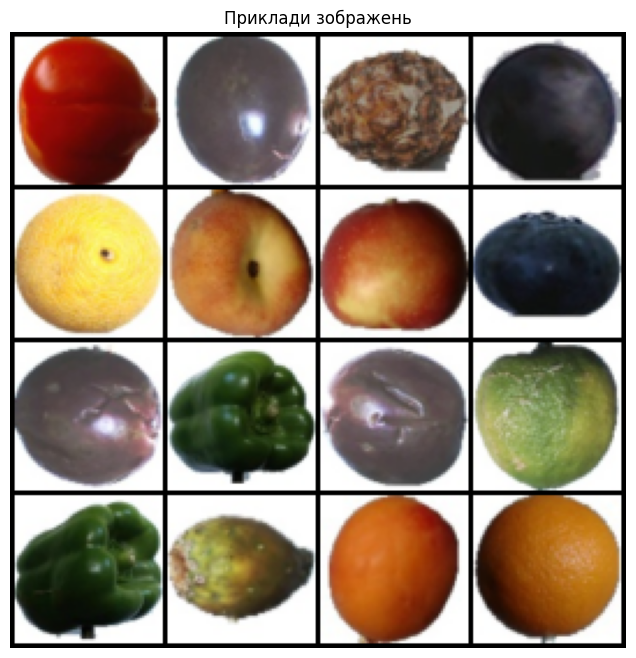

In [20]:
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images[:16], nrow=4).permute(1, 2, 0)
plt.figure(figsize=(8,8))
plt.imshow(grid)
plt.axis('off')
plt.title("Приклади зображень")
plt.show()

> ***#6. Модель***

In [21]:
class FruitModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 8 * 8, 200)
        self.fc2 = nn.Linear(200, len(class_names))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 8x32x32
        x = self.pool(F.relu(self.conv2(x)))  # 16x16x16
        x = self.pool(F.relu(self.conv3(x)))  # 32x8x8
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

> ***#7. Навчання***

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FruitModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            output = model(imgs)
            loss = loss_fn(output, labels)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Test Loss = {test_losses[-1]:.4f}")

Epoch 1: Train Loss = 1.9840, Test Loss = 0.6907
Epoch 2: Train Loss = 0.4475, Test Loss = 0.4005
Epoch 3: Train Loss = 0.2509, Test Loss = 0.1682
Epoch 4: Train Loss = 0.1567, Test Loss = 0.1611
Epoch 5: Train Loss = 0.1322, Test Loss = 0.0787
Epoch 6: Train Loss = 0.1143, Test Loss = 0.1132
Epoch 7: Train Loss = 0.0705, Test Loss = 0.1011
Epoch 8: Train Loss = 0.0714, Test Loss = 0.0620
Epoch 9: Train Loss = 0.0628, Test Loss = 0.0422
Epoch 10: Train Loss = 0.0261, Test Loss = 0.0412


> ***#8.Графік втрат***

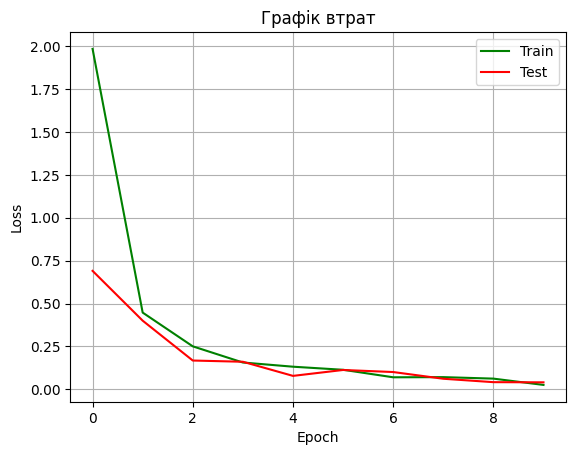

In [23]:
plt.plot(train_losses, label="Train", color="green")
plt.plot(test_losses, label="Test", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Графік втрат")
plt.legend()
plt.grid(True)
plt.show()

> ***#9. Збереження моделі***

In [24]:
torch.save(model.state_dict(), "fruit_model.pth")
print("Модель збережено у 'fruit_model.pth'.")

Модель збережено у 'fruit_model.pth'.


> ***#10. Завантаження для інференсу***

In [25]:
model = FruitModel().to(device)
model.load_state_dict(torch.load("fruit_model.pth", map_location=device))
model.eval()

FruitModel(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=33, bias=True)
)

> ***#11.Перевірка класифікації 5 зображень***

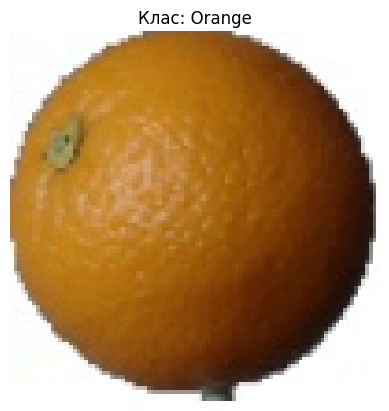

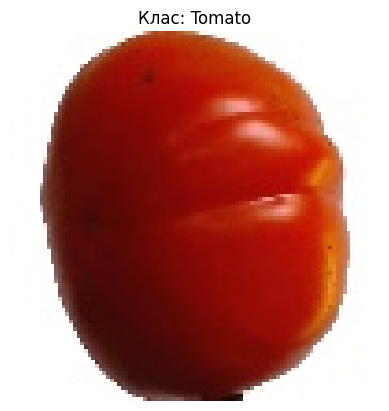

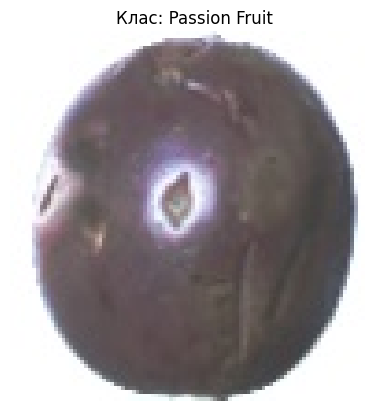

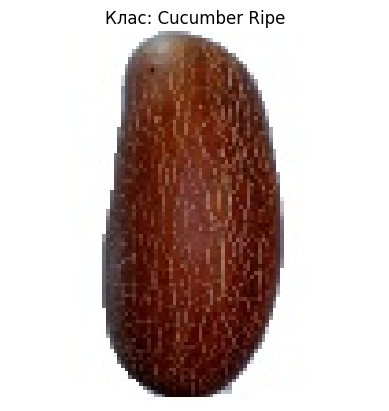

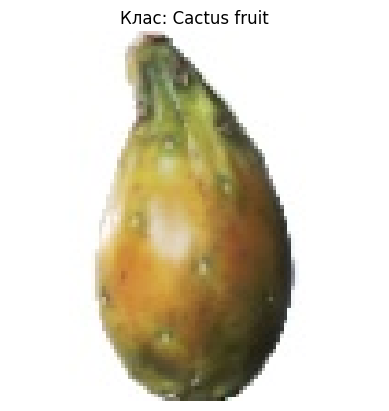

In [26]:
sample_images = []
for class_dir in os.listdir(dataset_path):
    full_class_path = os.path.join(dataset_path, class_dir)
    if os.path.isdir(full_class_path):
        imgs = glob(os.path.join(full_class_path, "*.jpg"))
        sample_images.extend(imgs[:1])
    if len(sample_images) >= 5:
        break

transform_eval = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

for path in sample_images:
    image = Image.open(path).convert("RGB")
    input_tensor = transform_eval(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_idx = torch.argmax(output, dim=1).item()
        label = class_names[pred_idx]

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Клас: {label}")
    plt.show()

> ***#12.Повна оцінка моделі***

In [27]:
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

> ***#13.Звіт і матриця плутанини***

Звіт класифікації:
                    precision    recall  f1-score   support

    Apple Braeburn       1.00      1.00      1.00       100
Apple Granny Smith       1.00      0.99      0.99        75
           Apricot       1.00      1.00      1.00       101
           Avocado       1.00      1.00      1.00        78
            Banana       1.00      1.00      1.00       109
         Blueberry       0.87      1.00      0.93        80
      Cactus fruit       1.00      0.91      0.95       102
        Cantaloupe       1.00      1.00      1.00       119
            Cherry       0.88      1.00      0.94       110
        Clementine       1.00      1.00      1.00       107
              Corn       1.00      1.00      1.00        89
     Cucumber Ripe       1.00      1.00      1.00        81
        Grape Blue       1.00      0.94      0.97       197
              Kiwi       1.00      1.00      1.00       102
             Lemon       1.00      1.00      1.00       101
             Limes  

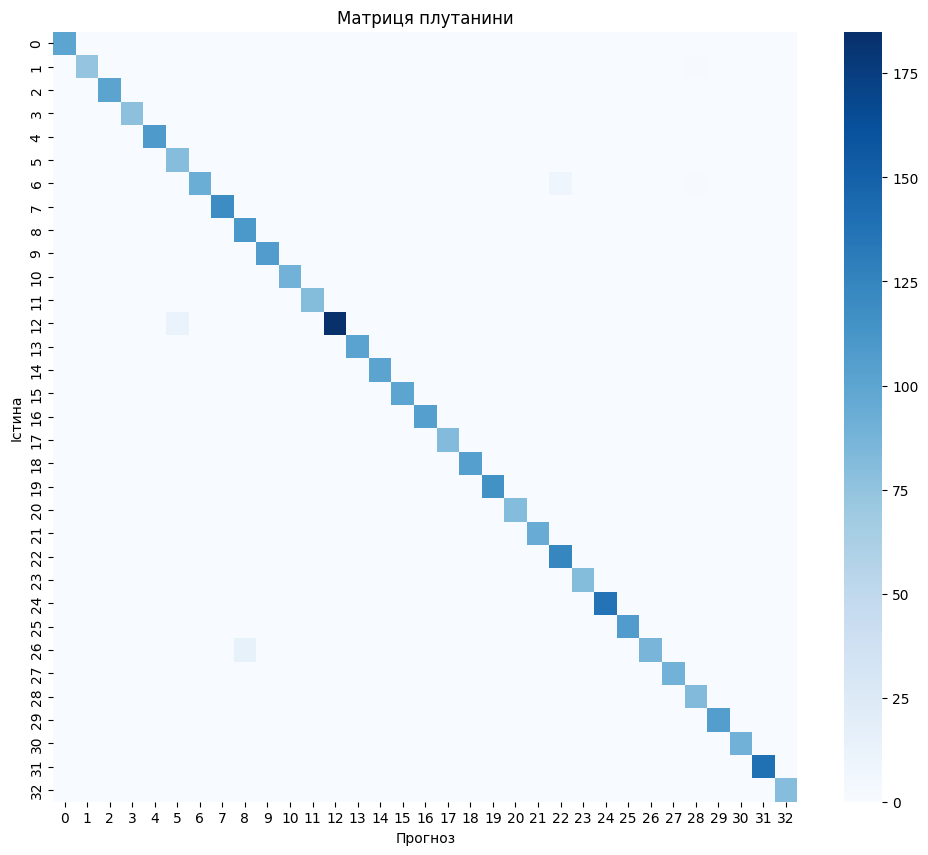

In [28]:
print("Звіт класифікації:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='g')
plt.title("Матриця плутанини")
plt.xlabel("Прогноз")
plt.ylabel("Істина")
plt.show()